In [1]:
"""

Pre-train a CNN on the whole dataset for evaluation purpose

"""
import os
import argparse
import shutil
import os
import timeit
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.backends.cudnn as cudnn
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from torch import autograd
from torchvision.utils import save_image
import csv
from tqdm import tqdm
import gc
import h5py

import copy
import eagerpy as ep

model_files_dir = "./model_files/" # 模型位置
sys.path.append(model_files_dir)
import model_files as model_all


In [2]:
device = torch.device("cuda:0")
netG_checkpoint = torch.load("./model_files/SteeringAngle/checkpoints/CcGAN/ckpt_CcGAN_niters_40000_seed_2020_hard.pth", map_location=device)
netG = model_all.get_generative_model("SteeringAngle")
netG = nn.DataParallel(netG, device_ids=[0])  #因为我们保存的参数就是nn.DataParallel(netG)封装好的参数，所以必须封装后才能读取这个参数
netG.load_state_dict(netG_checkpoint['netG_state_dict'])
netG.eval()
print("go")

go


In [3]:
class RegreAttack():
    def __init__(self, rel_stepsize: float = 0.01 / 0.3, steps: int = 40, bounds = (0, 1)):
        self.rel_stepsize = rel_stepsize
        self.steps = steps
        self.bounds = bounds
        self.loss_fn = nn.MSELoss()

    def get_random_start(self, x0, epsilon: float):
        x0, restore_type = ep.astensor_(x0)
        x = x0 + ep.uniform(x0, x0.shape, -epsilon, epsilon)
        return restore_type(x)

    def normalize(self, gradients):
        return gradients.sign()

    # 将
    def project(self, x, x0, epsilon: float):
        x, x_restore_type = ep.astensor_(x)
        x0, x0_restore_type = ep.astensor_(x0)
        temp = x0 + ep.clip(x - x0, -epsilon, epsilon)
        return x_restore_type(temp)
    
    def run(self, model, inputs, epsilon: float):
        x0 = inputs.clone().detach().requires_grad_()
        _min, _max = self.bounds
        init_label = model(x0)
        # print("攻击中的init_label: ", init_label)

        # 随机添加扰动，生成新的样本
        x = self.get_random_start(x0, epsilon)
        x = ep.clip(x, _min, _max)
        x = x.clone().detach().requires_grad_()

        # 梯度下降攻击
        for _ in range(self.steps):
            model.zero_grad()  # 清空模型参数的梯度信息
            # 计算扰动后的损失
            output = model(x)
            mse_loss = self.loss_fn(init_label, output)
            mse_loss.backward(retain_graph=True)
            gradients = x.grad.data

            gradients = self.normalize(gradients)
            x = x + self.rel_stepsize * gradients * epsilon
            x = self.project(x, x0, epsilon)
            x = ep.clip(x, _min, _max)
            x.grad = None  # 清空 x 的梯度信息
            x = x.clone().detach_().requires_grad_()
        return x

In [4]:
def adversarial_robustness_regre(model, img, label, device):
    # print("获取对抗鲁棒性中.....")
    image = img
    image = image.unsqueeze(0).to(device)  # 增加一个维度维batch维度
    copy_model = copy.deepcopy(model)
    copy_model.eval()

    attack = RegreAttack()
    epsilon = 0.001
    flag = False
    while(flag == False):
        if epsilon >= 0.033:
            break
        adv = attack.run(copy_model, image, epsilon=epsilon)
        label2 = model(adv)[0]
        # print("误差: ", abs(label2 - label))
        if abs(label2 - label) >= 0.05: # 0~1对应-80~80度，所以0.03125对应的是误差超过5度，0.05对应8度, 0.0625对应10度
            flag=True
        epsilon = epsilon + 0.001

    sys.stdout.flush()
    return epsilon-0.001

400
torch.Size([10, 3, 64, 64])


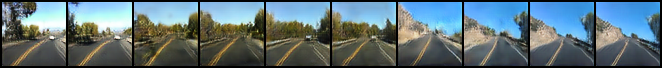

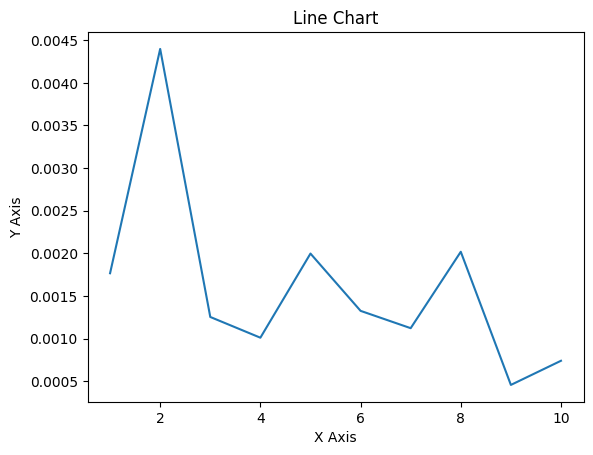

In [8]:
id_0 = 146
id_1 = 147

inter_number = 10

imgs_tensor_path = "./临时垃圾-随时可删/向量保存/zs_lst_400.pt"
zs_lst_400 = torch.load(imgs_tensor_path)
print(len(zs_lst_400))
z_and_embed1 = zs_lst_400[id_0].to(device)
z_and_embed2 = zs_lst_400[id_1].to(device)
label = z_and_embed1[256:].to(device)
# z_and_embed2[256:] = label #替换z2中的label
# 插值inter_number个
interpolated_z_and_embed = torch.zeros((inter_number, z_and_embed1.shape[0]))  # 初始化插值数组
for i in range(inter_number):
    interpolated_z_and_embed[i] = z_and_embed1 * (inter_number - i - 1) / (inter_number - 1) + z_and_embed2 * i / (inter_number - 1)

# alpha = torch.linspace(0, 1, inter_number, dtype=torch.float32).unsqueeze(1).to(device)
# print(z_and_embed1.shape)
# print(z_and_embed2.shape)
# interpolated_z_and_embed = torch.lerp(z_and_embed1, z_and_embed2, alpha).to(device)


interpolated_z = interpolated_z_and_embed[:, :256].to(device)
interpolated_fake_embed = interpolated_z_and_embed[:, 256:].to(device)

fake_images = netG(interpolated_z, interpolated_fake_embed)
temp_images = fake_images
print(fake_images.shape)
import torchvision.utils as vutils

# 将 fake_images 转换为可视化的图片，需要将像素值从 [-1, 1] 转换到 [0, 1] 的范围内
fake_images = (fake_images + 1) / 2

# 将 fake_images 保存到文件中
vutils.save_image(fake_images, 'generated_images.png', nrow=inter_number, normalize=True)

from IPython.display import Image

# 读取生成的图片
generated_image = Image(filename='generated_images.png')

# 显示图片
display(generated_image)

# 模型加载
dataset_type = "SteeringAngle"
model_name = "ResNet34_regre"
DNN_model = model_all.get_DNN_model(dataset_type, model_name)
DNN_model.load_state_dict(torch.load("./model_files/" + dataset_type + "/checkpoints/regre_model/" + model_name + ".pt", map_location=device)['net_state_dict'])
DNN_model = DNN_model.to(device)
DNN_model.eval()
rob_predictor = model_all.get_rob_predictor(dataset_type, model_name)
rob_predictor.load_state_dict((torch.load("./model_files/"+ dataset_type + "/checkpoints/rob_predictor/kjl_rob_predictor_" + model_name + "_wrongAngel=8.0epsilon=0.001epsilon_step=0.001.pt", map_location=device)))
rob_predictor = rob_predictor.to(device)
rob_predictor.eval()

# 定义中间变量字典
activation = {}
# 用来获取模型中间层输出的hook
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

if dataset_type == "CIFAR10":
    imgs = netG(interpolated_z_and_embed)   
    layers = DNN_model(imgs) #分类模型分类图片
    label = torch.argmax(layers, dim=1)
elif dataset_type == "SteeringAngle":
    imgs = netG(interpolated_z_and_embed[:, :256], interpolated_z_and_embed[:, 256:])
    # 注册钩子函数到第二层
    DNN_model.pool1.register_forward_hook(get_activation('pool1'))
    label = DNN_model(imgs)
    layers = activation['pool1']
    layers = layers.view(layers.size(0), -1)

robustness = rob_predictor(layers) #鲁棒性预测网络预测图片
data = robustness.detach().cpu()

# robustness = []
# for i in range(inter_number):
#     robustness.append(adversarial_robustness_regre(DNN_model, temp_images[i], label[i], device))
    # data = robustness
# print(robustness)


# 生成x坐标轴数据
x = np.arange(1, inter_number+1)
# 绘制折线图
plt.plot(x, data)
# 添加标题和轴标签
plt.title('Line Chart')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')

# 显示图形
plt.show()

In [6]:
dataset_type = "SteeringAngle"
model_name = "ResNet34_regre"
DNN_model = model_all.get_DNN_model(dataset_type, model_name)
DNN_model.load_state_dict(torch.load("./model_files/" + dataset_type + "/checkpoints/regre_model/" + model_name + ".pt", map_location=device)['net_state_dict'])
DNN_model = DNN_model.to(device)
DNN_model.eval()
rob_predictor = model_all.get_rob_predictor(dataset_type, model_name)
rob_predictor.load_state_dict((torch.load("./model_files/"+ dataset_type + "/checkpoints/rob_predictor/kjl_rob_predictor_" + model_name + "_wrongAngel=8.0epsilon=0.001epsilon_step=0.001.pt", map_location=device)))
rob_predictor = rob_predictor.to(device)
rob_predictor.eval()

Rob_predictor(
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)

tensor([[0.0018],
        [0.0023],
        [0.0035],
        [0.0052],
        [0.0052],
        [0.0044],
        [0.0047],
        [0.0046],
        [0.0044],
        [0.0044]], device='cuda:0', grad_fn=<AddmmBackward>)


ValueError: x and y must have same first dimension, but have shapes (40,) and torch.Size([10, 1])

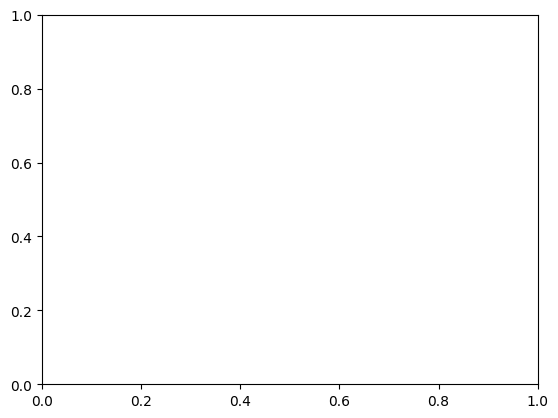

In [7]:
# 定义中间变量字典
activation = {}
# 用来获取模型中间层输出的hook
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

if dataset_type == "CIFAR10":
    imgs = netG(interpolated_z_and_embed)   
    layers = DNN_model(imgs) #分类模型分类图片
    label = torch.argmax(layers, dim=1)
elif dataset_type == "SteeringAngle":
    imgs = netG(interpolated_z_and_embed[:, :256], interpolated_z_and_embed[:, 256:])
    # 注册钩子函数到第二层
    DNN_model.pool1.register_forward_hook(get_activation('pool1'))
    label = DNN_model(imgs)
    layers = activation['pool1']
    layers = layers.view(layers.size(0), -1)

robustness = rob_predictor(layers) #鲁棒性预测网络预测图片
print(robustness)
data = robustness.detach().cpu()
# 生成x坐标轴数据
x = np.arange(1, 41)
# 绘制折线图
plt.plot(x, data)
# 添加标题和轴标签
plt.title('Line Chart')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')

# 显示图形
plt.show()